In [65]:
import numpy as np
import pandas as pd
import math
import time
import os.path
import xgboost as xgb
import gc
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
import time
import os
%matplotlib inline
from sklearn.model_selection import train_test_split

Import training and testing files.

In [66]:
X_train = pd.read_csv('/Users/hanxing/Desktop/Data Mining Project/mnt 2/ssd/kaggle-talkingdata2/competition_files/train.csv', nrows=100000, parse_dates=['click_time'])
X_test = pd.read_csv('/Users/hanxing/Desktop/Data Mining Project/test.csv', nrows=100000, parse_dates=['click_time'])

Parse the date object into day, hour, minute and second.

In [67]:
X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')

X_test['day'] = X_train['click_time'].dt.day.astype('uint8')
X_test['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_test['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_test['second'] = X_train['click_time'].dt.second.astype('uint8')

In [68]:
feature_list = list(X_train.columns.values)

Generate IP_App combination.

In [69]:
X_train['ip_app']=X_train.apply(lambda row: str(row.ip)+'_' 
                                                + str(row.app), axis=1)
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_app
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,32,21,83230_3
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,33,34,17357_3
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,34,12,35810_3
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,34,52,45745_14
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,35,8,161007_3


Feature Engineering: calculate the number clicks for the same app in the same day before the current click

In [70]:
prior_count=0
pre_app=0
pre_date=datetime.now().date()

idx=[]
app_click_counts=[]
for index, row in X_train.iterrows():
    cur_app=row['app']
    cur_date=row['day']
    
    if cur_app==pre_app and pre_date==cur_date:
        prior_count=prior_count+1
        #print(prior_count)
    else:
        prior_count=0
        pre_app=cur_app
        pre_date=cur_date
    idx.append(index)
    app_click_counts.append(prior_count)  

df_freq=pd.DataFrame({'id':idx,
                        #'tmp_id':tmp_ids,
                       'app_click_count':app_click_counts
                       }
                      )

#combine the app_click_count 

X_train['id']=X_train.index #re-assign id

X_train=pd.merge(X_train, df_freq,
         how='left', on='id')

X_train.head()


X_train=X_train.sort_values(by=['app','channel','click_time'],ascending=True)
X_train=X_train.reset_index(drop=True)

Calculate how many clicks have been made via the same ip + app + device + os + channel

In [71]:
X_train['tmp_id']=X_train.apply(lambda row: str(row.ip)+'_' 
                                                + str(row.app)+'_'
                                                + str(row.device)+'_'
                                                + str(row.os)+'_'
                                                + str(row.channel), axis=1)

In [72]:
X_train=X_train.sort_values(by=['tmp_id','click_time'],ascending=True)
X_train=X_train.reset_index(drop=True)
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_app,id,app_click_count,tmp_id
0,100002,15,1,13,140,2017-11-06 16:00:37,NaN,0,6,16,0,37,100002_15,30302,0,100002_15_1_13_140
1,100002,15,1,13,140,2017-11-06 16:00:52,NaN,0,6,16,0,52,100002_15,47847,0,100002_15_1_13_140
2,100002,1,1,13,134,2017-11-06 16:00:38,NaN,0,6,16,0,38,100002_1,31546,0,100002_1_1_13_134
3,100002,1,1,13,134,2017-11-06 16:00:53,NaN,0,6,16,0,53,100002_1,48214,0,100002_1_1_13_134
4,100002,8,1,13,145,2017-11-06 16:00:37,NaN,0,6,16,0,37,100002_8,30308,0,100002_8_1_13_145


Iterate through the dataframe to count how many clicks had been made before the current click by same ip+app+device+os+channel this time regardless of click time

In [73]:
pre_tmp_id=''
prior_count=0

idx=[]
#tmp_ids=[]
click_counts=[]
for index, row in X_train.iterrows():
    cur_tmp_id=row['tmp_id']
    
    if cur_tmp_id==pre_tmp_id:
        prior_count=prior_count+1
        #print(prior_count)
    else:
        prior_count=0
        pre_tmp_id=cur_tmp_id
    idx.append(index)
    #tmp_ids.append(cur_tmp_id)
    click_counts.append(prior_count)  

    
df_click_freq=pd.DataFrame({'id':idx,
                            #'tmp_id':tmp_ids,
                           'prior_click_count':click_counts
                           }
                          )


#df_train_sample=df_train_sample.drop(['prior_click_count','tmp_id_x','tmp_id_y'],axis=1)
X_train['id']=X_train.index

X_train=pd.merge(X_train, df_click_freq,
         how='left', on='id')

X_train=X_train.drop(['tmp_id'],axis=1)

X_train[X_train['prior_click_count']>1].head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_app,id,app_click_count,prior_click_count
6,100002,8,1,13,145,2017-11-06 16:00:39,NaN,0,6,16,0,39,100002_8,6,0,2
7,100002,8,1,13,145,2017-11-06 16:00:51,NaN,0,6,16,0,51,100002_8,7,1,3
8,100002,8,1,13,145,2017-11-06 16:00:52,NaN,0,6,16,0,52,100002_8,8,0,4
9,100002,8,1,13,145,2017-11-06 16:00:54,NaN,0,6,16,0,54,100002_8,9,0,5
37,100042,12,1,19,259,2017-11-06 16:01:41,NaN,0,6,16,1,41,100042_12,37,0,2


Feature Engineering: calculate the confidence rate.

In [74]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ###############
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ###############
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = X_train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    X_train = X_train.merge(
        group_object['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'is_attributed': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
X_train.head()

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate. Group Max /Mean / Median / Min: 610 / 6.51 / 3.0 / 1
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate. Group Max /Mean / Median / Min: 13280 / 847.46 / 5.0 / 1
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate. Group Max /Mean / Median / Min: 94397 / 1694.92 / 1.0 / 1
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate. Group Max /Mean / Median / Min: 23957 / 1052.63 / 67.0 / 1
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate. Group Max /Mean / Median / Min: 10582 / 751.88 / 188.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'channel'].
   Saving to: app_channel_confRate. Group Max /Mean / Median / Min: 10015 / 315.46 / 24.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'os'].
   Saving to: app_os_confRate. Group Max /Mean / Median / Min: 3236 / 65.83

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,app_confRate,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate
0,100002,15,1,13,140,2017-11-06 16:00:37,NaN,0,6,16,...,0.000000,0.001307,0.001149,0.000541,0.000000,0.0,0.000000,0.000000,0.000562,0.001187
1,100002,15,1,13,140,2017-11-06 16:00:52,NaN,0,6,16,...,0.000000,0.001307,0.001149,0.000541,0.000000,0.0,0.000000,0.000000,0.000562,0.001187
2,100002,1,1,13,134,2017-11-06 16:00:38,NaN,0,6,16,...,0.000000,0.001307,0.001149,0.000417,0.000000,0.0,0.000000,0.000302,0.000426,0.001187
3,100002,1,1,13,134,2017-11-06 16:00:53,NaN,0,6,16,...,0.000000,0.001307,0.001149,0.000417,0.000000,0.0,0.000000,0.000302,0.000426,0.001187
4,100002,8,1,13,145,2017-11-06 16:00:37,NaN,0,6,16,...,0.001329,0.001307,0.001149,0.001065,0.001119,0.0,0.001369,0.000000,0.001096,0.001187


Generate the IP_App combination of the test set.

In [75]:
X_test['ip_app']=X_test.apply(lambda row: str(row.ip)+'_' 
                                                + str(row.app), axis=1)
X_test.head()

,click_id,ip,app,device,os,channel,click_time,day,hour,minute,second,ip_app
0,0,5744,9,1,3,107,2017-11-10 04:00:00,6,14,32,21,5744_9
1,1,119901,9,1,3,466,2017-11-10 04:00:00,6,14,33,34,119901_9
2,2,72287,21,1,19,128,2017-11-10 04:00:00,6,14,34,12,72287_21
3,3,78477,15,1,13,111,2017-11-10 04:00:00,6,14,34,52,78477_15
4,4,123080,12,1,13,328,2017-11-10 04:00:00,6,14,35,8,123080_12


Merge training set to the test set if they have the same IP-App combination.

In [76]:
baseline = X_train.drop(labels=feature_list, axis=1)
X_test = pd.merge(X_test, baseline, how='left', on='ip_app')
X_test.head()

,click_id,ip,app,device,os,channel,click_time,day,hour,minute,...,app_confRate,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate
0,0,5744,9,1,3,107,2017-11-10 04:00:00,6,14,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,119901,9,1,3,466,2017-11-10 04:00:00,6,14,33,...,0.000745,0.001307,0.001149,0.000529,0.000675,0.000690,0.000789,0.000957,0.000556,0.001187
2,1,119901,9,1,3,466,2017-11-10 04:00:00,6,14,33,...,0.000745,0.001307,0.000141,0.000417,0.000709,0.000000,0.000789,0.000000,0.000426,0.000147
3,1,119901,9,1,3,466,2017-11-10 04:00:00,6,14,33,...,0.000745,0.001307,0.001389,0.000529,0.000675,0.000651,0.000789,0.000884,0.000556,0.001429
4,2,72287,21,1,19,128,2017-11-10 04:00:00,6,14,34,...,0.000350,0.001307,0.001389,0.000350,0.000000,0.001244,0.000424,0.000000,0.000425,0.001429


In [77]:
X_test.fillna(0, inplace=True)

Generate all group by features.

In [78]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: float(len(x)) / len(x.unique()), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp_train = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
    
    gp_test = X_test[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp_train[0].values
        X_test[new_feature] = gp_test[0].values
    else:
        X_train = X_train.merge(gp_train, on=spec['groupby'], how='left')
        X_test = X_test.merge(gp_test, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp_train
    del gp_test
    gc.collect()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nu

Generate time till next clicks.

In [79]:
GROUP_BY_NEXT_CLICKS = [
    
    # V1
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    X_train[new_feature] = X_train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    X_test[new_feature] = X_test[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds

>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}


Generate the number of clicks before and after the current click.

In [80]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    X_train['prev_'+fname] = X_train. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
        
    # Clicks in the future
    X_train['future_'+fname] = X_train.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]
        
    X_test['prev_'+fname] = X_test. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
        
    X_test['future_'+fname] = X_test. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname)

In [81]:
X_train.drop('ip_app', inplace=True, axis=1)
X_test.drop('ip_app', inplace=True, axis=1)

Pearson correlation with label "is_attributed".

In [18]:
df_corr = X_train.corr()
df_corr['is_attributed'][1:].sort_values(ascending=False)

is_attributed                         1.000000
app_channel_confRate                  0.486469
app_confRate                          0.470953
app_device_confRate                   0.467711
app_os_confRate                       0.418919
channel_os_confRate                   0.409634
channel_confRate                      0.393984
channel_device_confRate               0.389630
ip_confRate                           0.327075
os_confRate                           0.203557
os_device_confRate                    0.193273
device_confRate                       0.169151
app                                   0.046824
ip_os_device_nextClick                0.007427
ip_os_nextClick                       0.007308
ip_os_device_app_nextClick            0.003130
device                                0.000390
second                                0.000108
hour                                 -0.000316
minute                               -0.000318
ip_app_channel_mean_hour             -0.000319
ip_channel_ne

In [29]:
#define the function to get feature rankings
from sklearn.feature_selection import RFECV
    

def get_features(clf,score,X,y):
    skf=StratifiedKFold(n_splits=10,shuffle=False,random_state=42)
    rfecv = RFECV(estimator=clf, step=1, cv=skf,
              scoring=score)
    rfecv.fit(X, y)
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    rfecv_array=(list(rfecv.grid_scores_),list(rfecv.support_),list(rfecv.ranking_))
    return rfecv_array

Visualization of each feature.

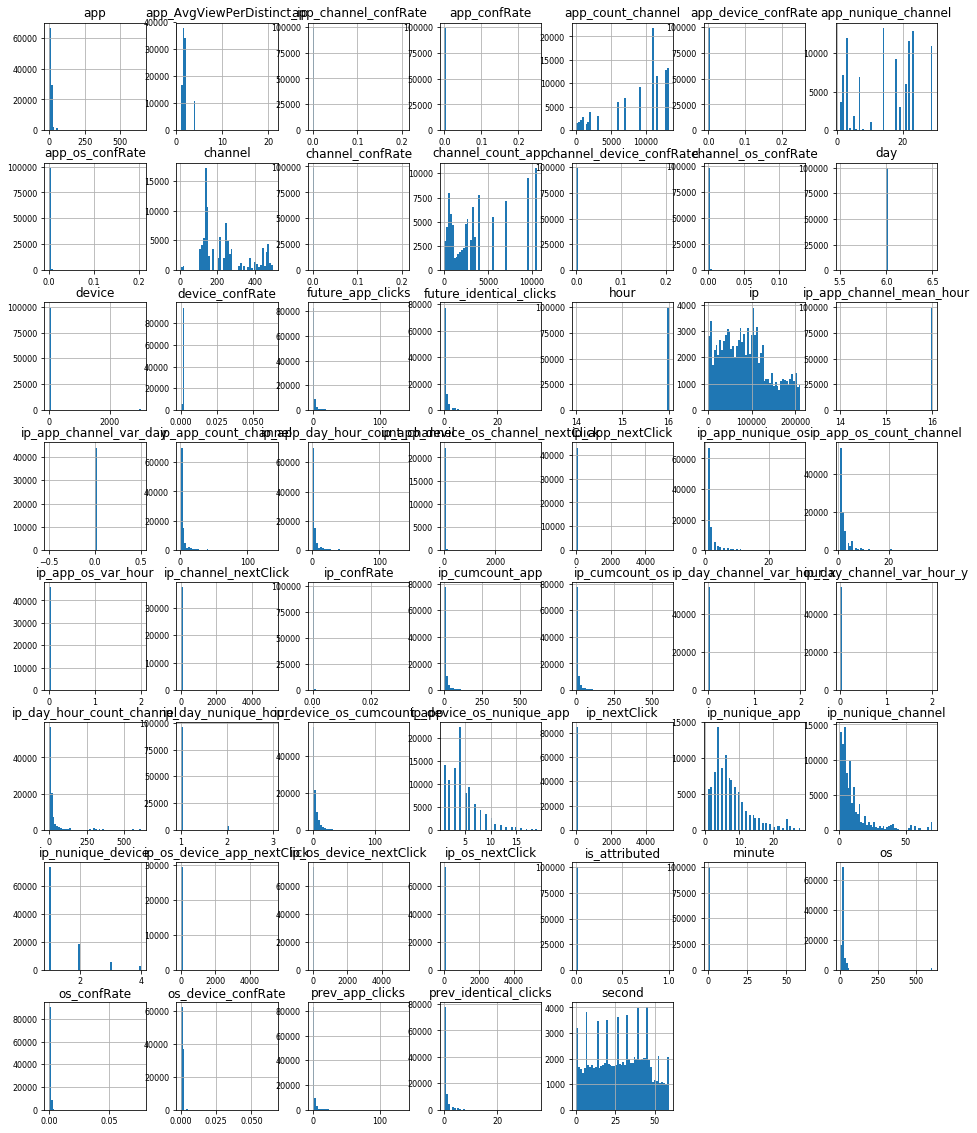

In [19]:
col_names=list(X_train.columns.values)
X_train[col_names].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Correlation table of each feature.

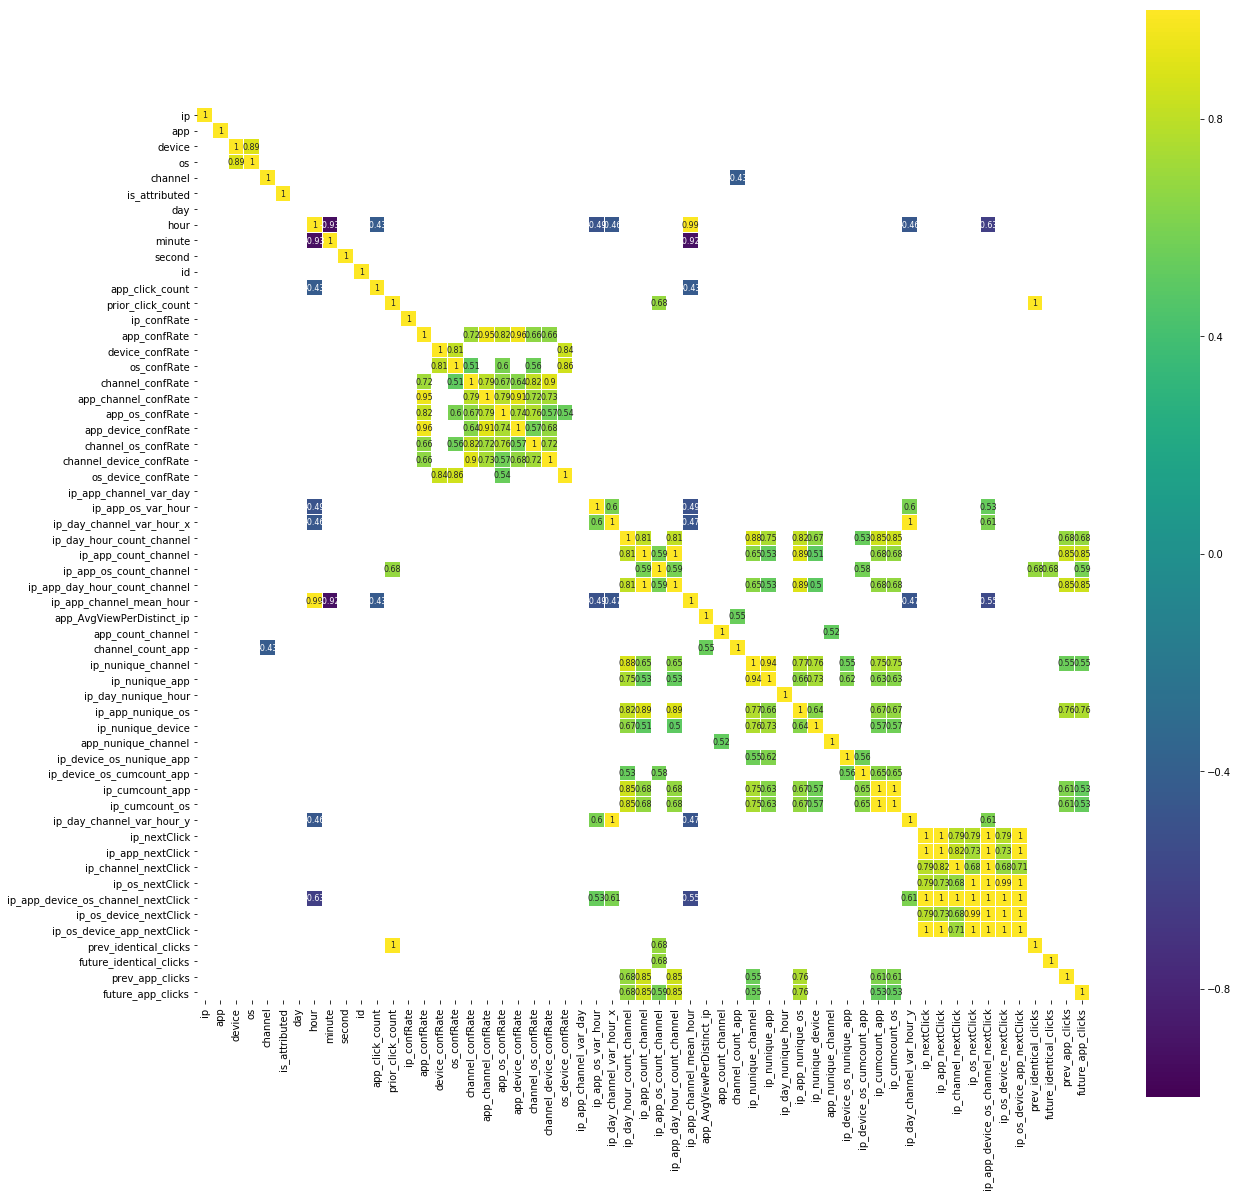

In [19]:
#correlation 
corr = X_train.corr() 
plt.figure(figsize=(20, 20))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [ ]:
sns.pairplot(X_train, hue='is_attributed', size=2.5)

Use the best set of parameters of XGBoost to fit the model.

In [15]:
# Split into X and y
y = X_train['is_attributed']
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=0, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=4, reg_lambda=1, scale_pos_weight=9, seed=None,
       silent=True, subsample=0.8)

Evaluate feature importance.

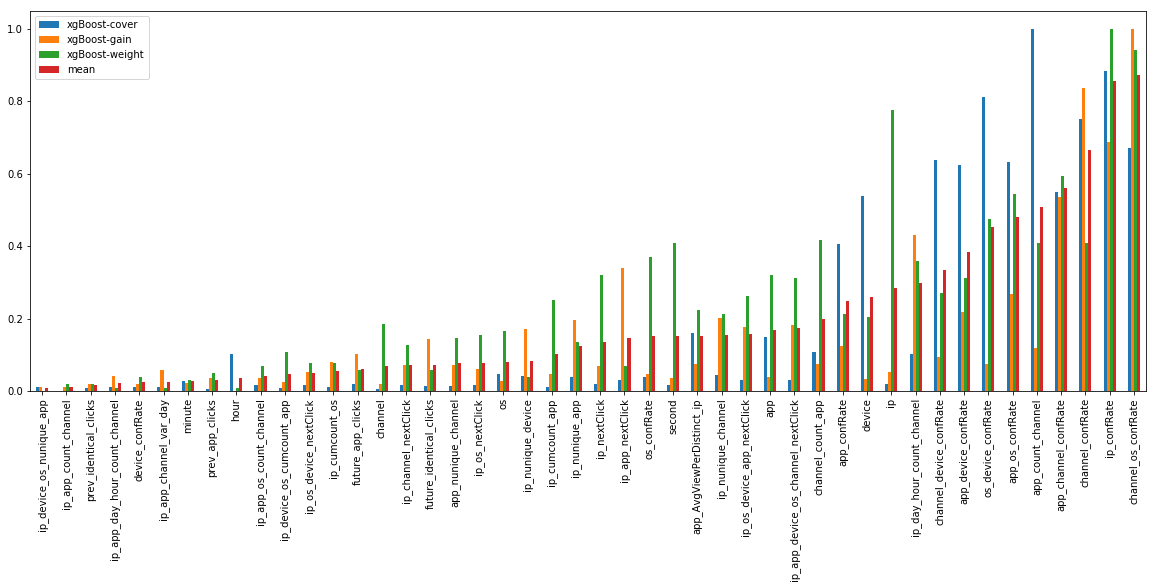

In [16]:
from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))

In [20]:
def print_duration (start_time, msg):
    print("[%d] %s" % (int(time.time() - start_time), msg))
    start_time = time.time()
    return start_time

In [164]:
# y_train = X_train['is_attributed']

def main():
    start_time = time.time()
    # create a xgboost model
    model = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 8,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = -1, 
    objective = 'binary:logistic'
)
        
    del X_train['is_attributed']
    del X_train['click_time']
    del X_train['attributed_time']
    del X_test['click_time']
    del X_test['click_id']
    X_Train, X_Test, y_Train, y_Test = train_test_split(X_train,y_train,test_size = 0.938, random_state=40)
    
    
    # fit the model
    
    auc_score = []
    model.fit(X_Train.as_matrix(), y_Train.as_matrix())
    y_pred_proba = model.predict_proba(X_Test.as_matrix())
        
    y_pred_prob = []
    for i in range(len(y_pred_proba)):
        y_pred_prob.append(y_pred_proba[i][1])
        
    fpr, tpr, _ = roc_curve(y_Test, y_pred_prob)        
    auc_score = roc_auc_score(y_Test.as_matrix(), y_pred_prob)
    
    plt.figure()
    plt.plot(fpr, tpr, color='navy', label='XGBoost (area = %0.3f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
#     start_time = print_duration (start_time, "Finished training, start prediction")
#     print(auc_score)

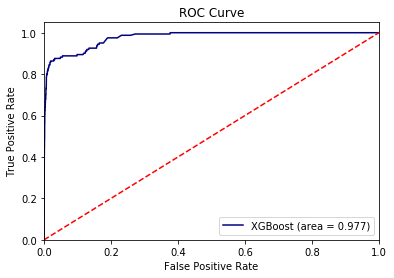

In [165]:
main()